## Group 3 - Project 2
# Online Shopper Purchase Prediction

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model as Group3Models
from math import sin, pi
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import os

#Create a fresh model_iterations_report
if os.path.exists('gen_model_iterations_report.csv'):
    os.remove('gen_model_iterations_report.csv')


### Read in CSV

In [2]:
"""Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q. https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset"""

online_shopping_df = pd.read_csv('Resources/online_shoppers_intention.csv')

### Preview Data

In [3]:
#Read in CSV
online_shopping_df = pd.read_csv('online_shoppers_intention.csv')

online_shopping_df.info()

online_shopping_df["Revenue"].value_counts()

# online_shopping_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

### Visualize Distributions for EDA

In [4]:
online_shopping_df_without_strings = online_shopping_df.copy()
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
online_shopping_df_without_strings["Month"] = online_shopping_df_without_strings["Month"].map(months)

visitor = {'New_Visitor': 1, 'Returning_Visitor': 2, 'Other': 3}
online_shopping_df_without_strings["VisitorType"] = online_shopping_df_without_strings["VisitorType"].map(visitor)

<Figure size 1200x600 with 0 Axes>

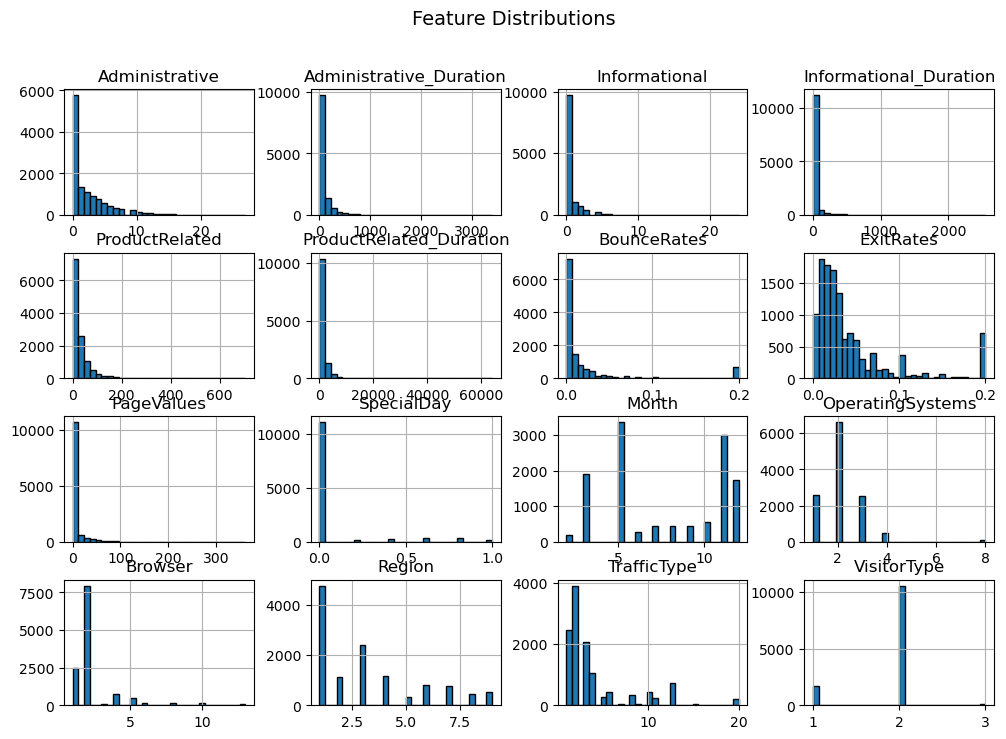


🔹 Boxplots for Outlier Detection


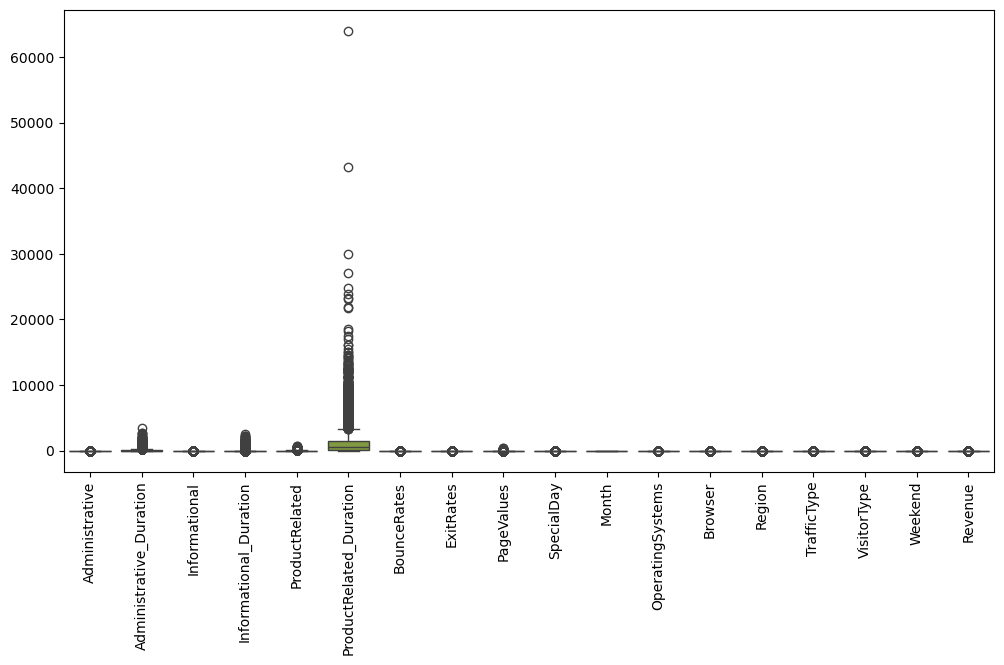


🔹 Correlation Heatmap


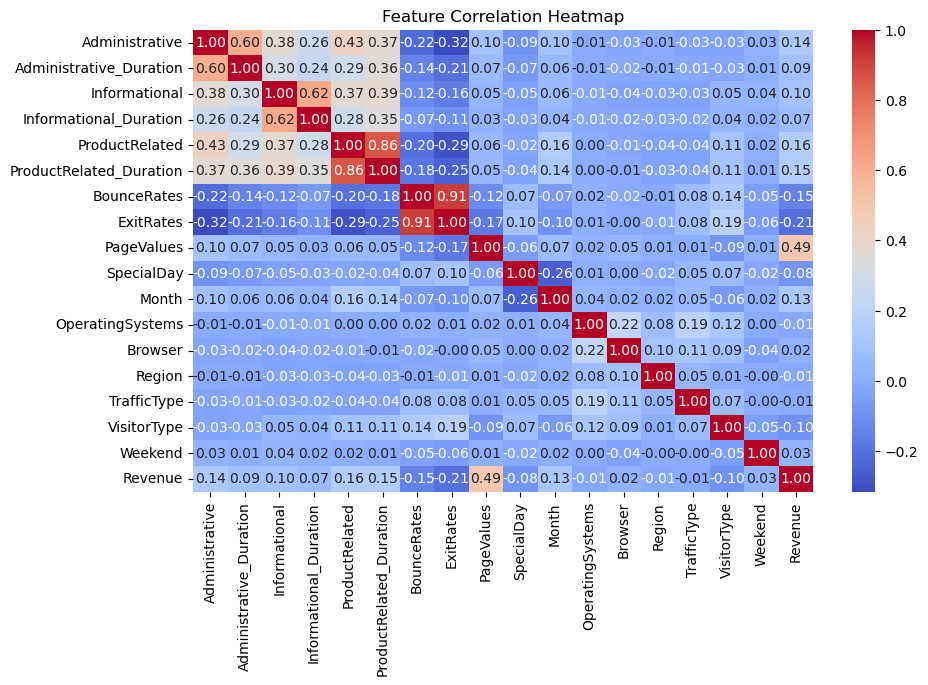

In [5]:
plt.figure()
corr_map = sns.heatmap(data=online_shopping_df_without_strings.corr(), annot=True, square=True, cbar_kws={"shrink": .8}, fmt='.2f', linewidths=.5)
corr_map.figure.set_size_inches(20, 25)
plt.title('Correlation Matrix', fontsize=20)
plt.show()

### Split data into training and test sets

In [6]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

# Set seed for reproducibility
SEED = 42

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=SEED)

### Scale and Encode Feature Columns

In [7]:
# Columns for numerical and categorical features
num_cols = ['PageValues', 'BounceRates', 'ExitRates']
cat_cols = ['VisitorType', 'Month']

# Ensure you fit the scaler on all numerical columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])  # Fit on the training data
X_test[num_cols] = scaler.transform(X_test[num_cols])  # Use the same scaler for the test set

# Save the scaler for later use
dump(scaler, "scaler.pkl")

# Apply one-hot encoding to categorical columns
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

# Check the updated columns
print(X_train.columns)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep'],
      dtype='object')


### Use SMOTEEN to oversample and balance the classes

In [8]:
#SMOTEEN the X_train, y_train to balance the classes
smote = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
X_train_bal.columns
print(pd.Series(y_train_bal).value_counts())

Revenue
True     1920
False    1356
Name: count, dtype: int64


### Create report on model performances

#### ADABoost

In [9]:
#Without SMOTEEN
model = Group3Models.ADABoost_V1()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, "ADABoost_V1_1", "Without SMOTEENN, \n No HyperParameter Tuning", X_train, X_test, y_train, y_test)

c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Score:  0.888612522980426
Accuracy Score: 0.888612522980426
Balanced Accuracy Score: 0.7550597626993035
              precision    recall  f1-score   support

       False       0.92      0.95      0.94      7828
        True       0.66      0.56      0.61      1419

    accuracy                           0.89      9247
   macro avg       0.79      0.76      0.77      9247
weighted avg       0.88      0.89      0.88      9247

AUC Score: 0.7550597626993035
Large gap in score means overfitting: 
0.8958806357444048
0.888612522980426


In [10]:
#With SMOTEEN
model = Group3Models.ADABoost_V1()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, "ADABoost_V1_2", "With SMOTEENN, \n No HyperParameter Tuning", X_train_bal, X_test, y_train_bal, y_test, False)

c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Score:  0.888612522980426
Accuracy Score: 0.888612522980426
Balanced Accuracy Score: 0.7550597626993035
              precision    recall  f1-score   support

       False       0.92      0.95      0.94      7828
        True       0.66      0.56      0.61      1419

    accuracy                           0.89      9247
   macro avg       0.79      0.76      0.77      9247
weighted avg       0.88      0.89      0.88      9247

AUC Score: 0.7550597626993035
Large gap in score means overfitting: 
0.8229548229548229
0.888612522980426


In [11]:
#Without SMOTEEN
model = Group3Models.ADABoost_V2()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, "ADABoost_V2_1", "Without SMOTEENN, \n HyperParameter Tuning", X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.875 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.877 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.911 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.896 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.888 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.875 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.909 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.904 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.894 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.883 total time=   1.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   1.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.914 total time=   1.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.907 total time=   1.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.890 total time=   1.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.883 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.874 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.911 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.896 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.885 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.882 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.874 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.891 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.885 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.883 total time=   1.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.875 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.900 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.893 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.886 total time=   1.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.882 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.896 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.893 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.878 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.896 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.881 total time=   0.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.878 total time=   1.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.882 total time=   1.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.891 total time=   1.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.883 total time=   1.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.880 total time=   1.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Score:  0.8929382502433222
Accuracy Score: 0.8929382502433222
Balanced Accuracy Score: 0.7648268822675544
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7828
        True       0.68      0.58      0.62      1419

    accuracy                           0.89      9247
   macro avg       0.80      0.76      0.78      9247
weighted avg       0.89      0.89      0.89      9247

AUC Score: 0.7648268822675545
Large gap in score means overfitting: 
0.8984755108660396
0.8929382502433222


In [12]:
model = Group3Models.ADABoost_V2()
model.fit(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, "ADABoost_V2_2", "With SMOTEENN, \n HyperParameter Tuning", X_train_bal, X_test, y_train_bal, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.878 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.959 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.960 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.931 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.953 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.966 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.962 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.942 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.960 total time=   1.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   1.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.966 total time=   2.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.968 total time=   2.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.954 total time=   1.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.965 total time=   1.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.872 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.973 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.969 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.957 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.966 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.832 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.973 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.971 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.963 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.969 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.802 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.968 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.965 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.817 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.960 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.969 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.793 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.960 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.974 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.791 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.973 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.971 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.968 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.974 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Score:  0.8697956093868282
Accuracy Score: 0.8697956093868282
Balanced Accuracy Score: 0.8457819151215547
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      7828
        True       0.55      0.81      0.66      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.85      0.79      9247
weighted avg       0.90      0.87      0.88      9247

AUC Score: 0.8457819151215547
Large gap in score means overfitting: 
0.953907203907204
0.8697956093868282


In [13]:
#Without SMOTEEN
model = Group3Models.ADABoost_V3()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, "ADABoost_V3_1", "test", X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.875 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.877 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.911 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.896 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.888 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.875 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.909 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.904 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.894 total time=   0.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.883 total time=   1.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   1.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.914 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.907 total time=   1.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.890 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.883 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.874 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.911 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.896 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.885 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.882 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.874 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.891 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.885 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.883 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.875 total time=   1.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.900 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.893 total time=   0.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.886 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.882 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.1s
[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.896 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.893 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.878 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.896 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.881 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.878 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.882 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.891 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.883 total time=   0.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.880 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Score:  0.8929382502433222
Accuracy Score: 0.8929382502433222
Balanced Accuracy Score: 0.7648268822675544
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7828
        True       0.68      0.58      0.62      1419

    accuracy                           0.89      9247
   macro avg       0.80      0.76      0.78      9247
weighted avg       0.89      0.89      0.89      9247

AUC Score: 0.7648268822675545
Large gap in score means overfitting: 
0.8984755108660396
0.8929382502433222


In [14]:
model = Group3Models.ADABoost_V3()
model.fit(X_train_bal, y_train_bal)
model.best_estimator_
Group3Models.evaluate_model(model.best_estimator_, "ADABoost_V3_2", "test", X_train_bal, X_test, y_train_bal, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.878 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.959 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.960 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.931 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.953 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.966 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.962 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.942 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.960 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.966 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.968 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.954 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.965 total time=   1.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.872 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.973 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.969 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.957 total time=   0.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.966 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.832 total time=   0.6s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.973 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.971 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.963 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.969 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.802 total time=   1.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.968 total time=   1.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.965 total time=   2.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   1.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.817 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.4s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.960 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.969 total time=   0.3s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.793 total time=   0.8s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   1.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.960 total time=   0.7s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.974 total time=   0.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.791 total time=   0.9s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.973 total time=   1.0s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.971 total time=   1.1s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.968 total time=   1.2s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.974 total time=   1.5s


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Score:  0.8697956093868282
Accuracy Score: 0.8697956093868282
Balanced Accuracy Score: 0.8457819151215547
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      7828
        True       0.55      0.81      0.66      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.85      0.79      9247
weighted avg       0.90      0.87      0.88      9247

AUC Score: 0.8457819151215547
Large gap in score means overfitting: 
0.953907203907204
0.8697956093868282


#### Logistic Regression

In [15]:
#without SMOTEENN
model = Group3Models.model_logistic_regression_v1(X_train, y_train)
Group3Models.evaluate_model(model, "Logistic Regression V1_1", "Without SMOTEENN, \n No HyperParameter Tuning", X_train, X_test, y_train, y_test)

Best Parameters: 
{'C': 10, 'solver': 'lbfgs'}
Model Score:  0.8929382502433222
Accuracy Score: 0.8929382502433222
Balanced Accuracy Score: 0.716937950286336
              precision    recall  f1-score   support

       False       0.91      0.97      0.94      7828
        True       0.74      0.46      0.57      1419

    accuracy                           0.89      9247
   macro avg       0.83      0.72      0.75      9247
weighted avg       0.88      0.89      0.88      9247

AUC Score: 0.716937950286336
Large gap in score means overfitting: 
0.8809601037950049
0.8929382502433222


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
model = Group3Models.model_logistic_regression_v1(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, "Logistic Regression V1_2", "Without SMOTEENN, \n No HyperParameter Tuning", X_train_bal, X_test, y_train_bal, y_test)

Best Parameters: 
{'C': 100, 'solver': 'liblinear'}
Model Score:  0.8667676003028009
Accuracy Score: 0.8667676003028009
Balanced Accuracy Score: 0.8096634459051424
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      7828
        True       0.55      0.73      0.63      1419

    accuracy                           0.87      9247
   macro avg       0.75      0.81      0.77      9247
weighted avg       0.89      0.87      0.87      9247

AUC Score: 0.8096634459051424
Large gap in score means overfitting: 
0.9468864468864469
0.8667676003028009


In [17]:
#without SMOTEENN
model = Group3Models.model_logistic_regression_v2(X_train, y_train)
Group3Models.evaluate_model(model, "Logistic Regression V2_1", "Without SMOTEENN, \n HyperParameter Tuning", X_train, X_test, y_train, y_test)

Best Parameters: 
{'C': 200, 'solver': 'lbfgs'}
Model Score:  0.8881799502541364
Accuracy Score: 0.8881799502541364
Balanced Accuracy Score: 0.699991636607066
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      7828
        True       0.73      0.43      0.54      1419

    accuracy                           0.89      9247
   macro avg       0.82      0.70      0.74      9247
weighted avg       0.88      0.89      0.88      9247

AUC Score: 0.6999916366070661
Large gap in score means overfitting: 
0.8819331819656179
0.8881799502541364


c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
model = Group3Models.model_logistic_regression_v2(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, "Logistic Regression V2_2", "With SMOTEENN, \n HyperParameter Tuning", X_train_bal, X_test, y_train_bal, y_test)

Best Parameters: 
{'C': 100, 'solver': 'liblinear'}
Model Score:  0.8667676003028009
Accuracy Score: 0.8667676003028009
Balanced Accuracy Score: 0.8096634459051424
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      7828
        True       0.55      0.73      0.63      1419

    accuracy                           0.87      9247
   macro avg       0.75      0.81      0.77      9247
weighted avg       0.89      0.87      0.87      9247

AUC Score: 0.8096634459051424
Large gap in score means overfitting: 
0.9468864468864469
0.8667676003028009


#### Pipeline Logistic Regression

In [19]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('model', LogisticRegression())  # Train classifier
])

In [20]:
pipeline.fit(X_train, y_train)

Group3Models.evaluate_model(pipeline,  "Logistic Regression V3_1", "Pipeline with Standard Scaler and Logistic Regression without SMOTEENN",X_train, X_test, y_train, y_test)


Model Score:  0.8873148048015572
Accuracy Score: 0.8873148048015572
Balanced Accuracy Score: 0.6919799743102497
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      7828
        True       0.74      0.41      0.53      1419

    accuracy                           0.89      9247
   macro avg       0.82      0.69      0.73      9247
weighted avg       0.88      0.89      0.87      9247

AUC Score: 0.6919799743102497
Large gap in score means overfitting: 
0.8803113850145962
0.8873148048015572


In [21]:
pipeline.fit(X_train_bal, y_train_bal)

Group3Models.evaluate_model(pipeline, "Logistic Regression V3_2", "Pipeline with Standard Scaler and Logistic Regression with SMOTEENN", X_train_bal, X_test, y_train_bal, y_test)



Model Score:  0.8652535957607873
Accuracy Score: 0.8652535957607873
Balanced Accuracy Score: 0.795498793114686
              precision    recall  f1-score   support

       False       0.94      0.90      0.92      7828
        True       0.55      0.69      0.61      1419

    accuracy                           0.87      9247
   macro avg       0.74      0.80      0.77      9247
weighted avg       0.88      0.87      0.87      9247

AUC Score: 0.7954987931146859
Large gap in score means overfitting: 
0.9416971916971917
0.8652535957607873


#### Random Forest

In [22]:
model = Group3Models.model_random_forest_model_V1(X_train, y_train)
Group3Models.evaluate_model(model, "Random Forest V1_1", "Without SMOTEENN, \n No HyperParameter Tuning", X_train, X_test, y_train, y_test)


Model Score:  0.9024548502216935
Accuracy Score: 0.9024548502216935
Balanced Accuracy Score: 0.7566003284859864
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      7828
        True       0.75      0.55      0.63      1419

    accuracy                           0.90      9247
   macro avg       0.84      0.76      0.79      9247
weighted avg       0.90      0.90      0.90      9247

AUC Score: 0.7566003284859864
Large gap in score means overfitting: 
1.0
0.9024548502216935


In [23]:
model = Group3Models.model_random_forest_model_V1(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model,"Random Forest V1_2", "With SMOTEENN, \n No HyperParameter Tuning", X_train_bal, X_test, y_train_bal, y_test)


Model Score:  0.8744457661944415
Accuracy Score: 0.8744457661944415
Balanced Accuracy Score: 0.8450666154600155
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      7828
        True       0.56      0.80      0.66      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.85      0.79      9247
weighted avg       0.90      0.87      0.88      9247

AUC Score: 0.8450666154600155
Large gap in score means overfitting: 
1.0
0.8744457661944415


In [24]:
model = Group3Models.model_random_forest_model_V2(X_train, y_train)
Group3Models.evaluate_model(model,"Random Forest V2_1", "Without SMOTEENN, \n HyperParameter Tuning", X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: 
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}
Model Score:  0.904185141126852
Accuracy Score: 0.904185141126852
Balanced Accuracy Score: 0.7532949877618984
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      7828
        True       0.77      0.54      0.63      1419

    accuracy                           0.90      9247
   macro avg       0.85      0.75      0.79      9247
weighted avg       0.90      0.90      0.90      9247

AUC Score: 0.7532949877618985
Large gap in score means overfitting: 
0.9756730457346741
0.904185141126852


In [25]:
model = Group3Models.model_random_forest_model_V2(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model,"Random Forest V2_2", "With SMOTEENN, \n HyperParameter Tuning", X_train_bal, X_test, y_train_bal, y_test)
dump(model, 'best_model_random_forest_balanced_hyperparameter_tuned.pkl')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: 
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Model Score:  0.8782307775494755
Accuracy Score: 0.8782307775494755
Balanced Accuracy Score: 0.8421094043427706
              precision    recall  f1-score   support

       False       0.96      0.89      0.93      7828
        True       0.58      0.79      0.67      1419

    accuracy                           0.88      9247
   macro avg       0.77      0.84      0.80      9247
weighted avg       0.90      0.88      0.89      9247

AUC Score: 0.8421094043427706
Large gap in score means overfitting: 
1.0
0.8782307775494755


['best_model_random_forest_balanced_hyperparameter_tuned.pkl']